# Setting up our Notebook

In this notebook, the setup and exploration of the environment heavily follows Nicholas Renotte's YouTube tutorial *Build an Mario AI Model with Python | Gaming Reinforcement Learning* at: https://www.youtube.com/watch?v=2eeYqJ0uBKE&t=1982s

Pertinent Links:

Super Mario RL: https://pypi.org/project/gym-super-mario-bros/

Nes Py: https://pypi.org/project/nes-py/

OpenAI Gym: https://gym.openai.com/

Stable Baselines 3: https://stable-baselines3.readthedocs.io/en/master/index.html

In [1]:
# Standard Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn_image as isns

# Stable Baselines and Logging
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

# Misc
import time
from PIL import Image

# from IPython.display import HTML

In [2]:
# Import the game
import gym_super_mario_bros

# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace # Needed for changing the action space

# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Misc
from gym.spaces import Box
from gym.wrappers import FrameStack

# Trust Region and Proximal Policy Optimization

## Basic Overview of Policy Gradient Algorithms

The REINFORCE algorithm starts from the concept of a trajectory, $\large \tau$, generated by an agent taking actions in states according to some policy parameterized (and therefore, an estimate) by $\mathbf{\theta}$:
$$a \approx \hat{\pi}(s, \mathbf{\theta})$$

This action could be discrete, as in this script, in which case the output of $\hat{\pi}(s, \mathbf{\theta})$ is then a *Categorical Distribution* and the action must then be *sampled*, or, in the continuous case, a $d$-dimensional multivariate normal distribution.

The agent follows the policy and generates the trajectory $\large \tau$: 

$$ s_1 \rightarrow a_1 \rightarrow s_2 \rightarrow a_2 \rightarrow .... \rightarrow s_{T-1} \rightarrow a_{T-1} \rightarrow s_T \rightarrow a_T$$ 

The probability of trajectory $\large \tau$ depends on the transition probabilities $p(s_t+1 | s_t, a_t)$ and the policy $\hat{\pi}(s, \mathbf{\theta})$. It is given by the expression:

$$p_\theta(\tau) = p_\theta(s_1, a_1, s_2, a_2, ..., s_T, a_T) = p(s_1)\prod_{t=1}^{T}\hat{\pi}(a_t|s_t,\mathbf{\theta})p(s_{t+1}|s_t,a_t)$$

The expected return from following the policy $\pi$ is given by:

$$J(\theta) = \mathbf{E}_{\tau \sim p_\mathbf{\theta}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right]$$

After some mathematical manipulation, we can calculate $\nabla_{\theta} J(\theta)$ as:

$$\nabla_{\theta} J(\theta) =  \mathbf{E}_{\tau \sim p_\theta(\tau)} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}(a_t|s_t,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

We can now replace the outer expectation with an estimate over multiple trajectories to get the following expression for the gradient of policy objective:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}_\theta(a_t^i|s_t^i,\mathbf{\theta})} \right) \left( \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right) \right] $$

where i denotes the $i^{th}$ trajectory. 

Finally, we will use *Gradient Ascent*, as opposed to the normal *Descent*:

$$\mathbf{\theta}_{k+1}=\mathbf{\theta}_k+\eta \nabla _{\mathbf{\theta}_k} J(\mathbf{\theta}_k)$$

## Rewards to Go Trick


We drop the reward terms that came before time t as at time t, the action we take can only impact the reward which comes at time t and later. This leads to changing the 2nd inner sum going from $t’=t$ to $T$ instead of earlier sum over $t’$ going from $t’=1$ to $T$. i.e. the start index is now $t’=t$ and not $t=1$. The revised expression is given below:


$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[  \sum_{t=1}^{T}  \left( \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} \right) \left( \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i \right) \right] $$

However, we note that $\sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$ is just the Q-value of the state and action at time $t'=t$, so we can replace it with $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$. We now have:

$$\nabla_{\theta} J(\theta) \approx  \frac{1}{N} \sum_{i=1}^{N} \left[\sum_{t=1}^{T}   \nabla_{\theta} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} Q_t ^i \right]$$

## Concepts Required for Trust Region/Proximal Policy Optimization Not Yet Introduced

###  Parameter Space versus Probability Space

We note that the following update equation:

$$\mathbf{\theta}_{k+1}=\mathbf{\theta}_k+\eta \nabla _{\mathbf{\theta}_k} J(\mathbf{\theta}_k)$$

takes a step in *parameter space*. However, we might ask, since the parameters are altering a probability distribution, how do we know if a small step in parameter space is a comparatively small space in probability space? We need a way ot compare the "distance" in probability space. To do so, we will introduce the *Kullback-Leiber Divergence*, denoted KL-divergence. Given two distributions, the discrete KL-divergence is:

$$ D_{KL}(P||Q) = \sum_{x} P(x) \log \frac{P(x)}{Q(x)} $$

The continuous case is:

$$ D_{KL}(P||Q) = \int P(x) \log \frac{P(x)}{Q(x)} dx $$

Since our probability distributions rely on both the parameters $\mathbf{\theta}$ *and* a state *s*, we will write this as:

$$ D_{KL} (\theta_{k+1} || \theta_k)[s] = \sum_{a \in \mathcal{A}} \hat{\pi}(a | s, \theta_{k+1})
\log \frac{\hat{\pi}(a | s, \theta_c)} {\hat{\pi} (a | s, \theta_k)}$$

We will be interested in the *average* KL-divergence, and we will denote $\theta_c$ as a candidate parameter set we might update to, giving us:

$$ \bar{D}_{KL} (\theta_c || \theta_k )= 
\mathbf{E}_{s \sim \hat{\pi}_{\theta_k}} \left[ D_{KL} (\theta_c || \theta_k)[s] \right]$$

We can then write it in Monte Carlo simulation form as:

$$ \bar{D}_{KL} (\theta_c || \theta_k )= 
\mathbf{E}_{s \sim \hat{\pi}_{\theta_k}} \left[ D_{KL} (\theta_c || \theta_k)[s] \right] =
\frac{1}{NT}\sum_{i=1}^{N} \left[ \sum_{t=1}^{T} \left[\sum_{a \in \mathcal{A}} \hat{\pi}(a | s^i _t, \theta_{k+1})
\log \frac{\hat{\pi}(a | s^i _t, \theta_c)} {\hat{\pi} (a | s^i _t, \theta_k)} \right] \right]
$$

### Importance Sampling

*Importance Sampling* is a technique for estimating expectations using samples drawn from a different distribution. It is defined as:

$$ \mathbf{E}_{x \sim P} \left[f(x) \right] = \mathbf{E}_{x \sim Q} \left[\frac{P(x)}{Q(x)} f(x) \right] \approx \frac{1}{D} \sum_{x \in D} \frac{P(x)}{Q(x)} f(x) $$ 

### Comparing two policies

We will reiterate the basic objective function in policy gradient algorithms, which we seek to maximize:

$$J(\theta) = J(\theta)_{expected} = \mathbf{E}_{\tau \sim p_\mathbf{\theta}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} r_{t+1} \right]$$

Now, we can ask, given a policy with parameters $\theta_k$ and a candidate (for updating) policy with parameters $\theta_c$, how can we compare them? We will use the following:

$$J(\theta_c) = J(\theta_k) + \mathbf{E}_{\tau \sim p_\mathbf{\theta_c}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} A(s_t, a_t, \theta_k) \right]$$

Thus, we can write an objective function in terms of both policies as:

$$ J(\theta_c) - J(\theta_k) = J(\theta_c, \theta_k) = \mathbf{E}_{\tau \sim p_\mathbf{\theta_c}(\tau)} \left[ \sum_{t=1}^{T} \gamma^{t-1} A(s_t, a_t, \theta_k) \right] $$

However, we have a problem, namely that our trajectory $\tau$ is being sampled from a policy *we do not have*. We will briefly describe how to handle this. 

First, we will decompose the trajectory into actions sampled from a policy with parameters $\theta_c$ and states sampled from *Discounted Future State Distribution*, defined as:

$$ \rho_{\theta} (s) = p(s_1 = s)+ \gamma p(s_2 = s)+ \gamma^2 p(s_3 = s) + ... = \sum_{t=1}^{\infty} \gamma^{t-1}p(s_t = s) $$

Now, we can use importance sampling to change the action from being sampled from a policy with parameters $\theta_c$ to parameters $\theta_k$ by adding the fraction above.

Then, we can make an assumption that $\rho_{\theta_c} \approx \rho_{\theta_k}$, which will be true so long as the following holds:

$$ J(\theta_c)-J(\theta_k) \geq J(\theta_c, \theta_k) - C\sqrt{\bar{D}_{KL} (\theta_c || \theta_k)} $$

Combining our action and state back into a trajectory, we get:

$$J(\theta_c, \theta_k) = \mathbf{E}_{\tau \sim \hat{\pi}_{\theta_k}}
\left[
\sum_{t=1}^T \frac{\hat{\pi}(a_t |s_t, \theta_c)}{\hat{\pi}(a_t | s_t, \theta_k)} A(s_t, a_t, \theta_k) \right] $$

## Statement of Trust Region Policy Optimization Algorithm

Now, we state our algorithm:

$$ \theta_{k+1} = max_{\theta_c}J(\theta_c || \theta_k)$$

Such that:

$$J(\theta_c, \theta_k) = \mathbf{E}_{\tau \sim \hat{\pi}_{\theta_k}}
\left[
\sum_{t=1}^T \frac{\hat{\pi}(a_t |s_t, \theta_c)}{\hat{\pi}(a_t | s_t, \theta_k)} A(s_t, a_t, \theta_k) \right] $$

and:

$$ \bar{D}_{KL}(\theta_c || \theta_k) \leq \delta $$

The way to interpret this is that we want to step in a direction in parameters space with the biggest improvement in policy with the caveat that our step in probability space not be too big. This $\delta$ is the *Trust REgion*, hence the name of the polcy.

### Approximations

Unfortunately, this is actually a bit difficult, so we will make some approximations.

First, we define:

$$ g = \nabla_{\theta_k} J(\theta_k, \theta_k) $$

Then, our first-order Taylor approximation to our objective function is:

$$ J(\theta_c, \theta_k) \approx g^T(\theta_c - \theta_k) $$

By happy coincidence, $g$ simplfies to our regular policy gradient equation:

$$ g = \nabla_{\theta_k} J(\theta_k, \theta_k) =
\mathbf{E}_{\tau \sim \hat{\pi}_{\theta_k}} \left[ \left( \sum_{t=1}^{T} \nabla_{\theta} \log{ \hat{\pi}(a_t|s_t,\mathbf{\theta_k})} \right) A(s^i _t, a^i _t, \theta_k) \right] \approx \frac{1}{N} \sum_{i=1}^{N} \left[ \sum_{t=1}^{T}   \nabla_{\theta_k} \log{ \hat{\pi}(a_t^i|s_t^i, \mathbf{\theta})} A(s^i _t, a^i _t, \theta_k) \right]$$

Then, we will approximate $\bar{D}_{KL}(\theta_c || \theta_k)$ by:

$$ \bar{D}_{KL}(\theta_c || \theta_k) \approx \frac{1}{2} (\theta_c - \theta_k)^T H (\theta_c - \theta_k) $$

Where:

$$ H = \nabla^2 _{\theta_k} \bar{D}_{KL}(\theta_c || \theta_k) $$


Our update rule *would* then be:

$$ \theta_{k+1} = \theta_k + \sqrt{\frac{2\delta}{g^T H^{-1} g}} H^{-1}g $$

However, to deal with the possibility that our approximations have introduced problems, we will use:

$$ \theta_{k+1} = \theta_k + \alpha^j \sqrt{\frac{2\delta}{g^T H^{-1} g}} H^{-1}g $$

Where $\alpha \in (0,1)$ and $j$ is the smallest nonnegative integer such that $\hat{\pi}(s, \theta_{k+1})$ satisfies the KL-divergence constraint and gives an actual improvement to our policy.

Finally, due the large computational cost of calculating $H$, we will approximate *that* by $Hx=g$. This gives us:

$$ \theta_{k+1} = \theta_k + \alpha^j \sqrt{\frac{2\delta}{x^T H^{-1} x}} x $$

## Statement of Proximal Policy Optimization (Clipped Version)

Now, we state our algorithm:

$$ \theta_{k+1} = max_{\theta_c}J(\theta_c || \theta_k)$$

Where:

$$ J(\theta_c, \theta_k) = \mathbf{E}_{a,s \sim \hat{\pi}_{\theta_k}} 
\left[ \min \left( \frac{\hat{\pi}(a_t |s_t, \theta_c)}{\hat{\pi}(a_t | s_t, \theta_k)} \right)
A(s_t, a_t, \theta_k), g(\epsilon, A(s_t, a_t, \theta_k)) \right] $$

And:

$$ g(\epsilon, A(s,a, \theta_k) =
\begin{cases}
(1+\epsilon)A, A\geq 0\\
(1-\epsilon)A, A <0
\end{cases}
$$

This is approximated by:

$$ J(\theta_c , \theta_k) \approx \frac{1}{NT} \sum_{i=1}^{N} \left[\sum_{t=1}^{T} \min \left(\frac{\hat{\pi}(a^i _t |s^i _t, \theta_c)} {\hat{\pi}(a^i _t | s^i _t, \theta_k)}
A(s^i _t, a^i _t, \theta_k), g(\epsilon, A(s^i _t, a^i _t, \theta_k)) \right) \right]$$

In either implementation, we would update our parameters in the manner above, but then, given that we are *also* approximating our advantage function, say, with parameters $\mathbf{\Theta}$, our loss function is:

$$ \mathcal{L}(\mathbf{\Theta}) = \frac{1}{NT} \sum_{i=1}^N \left[ \sum_{t=1}^T 
(V(s^i _t, \mathbf{\Theta}) - Q^i _t)^2 \right] $$

In the above, $Q_t ^i = \sum_{t'=t}^{T} \gamma^{t'-t} r_{t'+1}^i$

In this implementation, we will only be using the Proximal Policy Optimization algorithm, as it is simpler nad has similar results to Trust Region Policy Optimization.

# Exploring the game

In [3]:
# Setting up the game

env = gym_super_mario_bros.make('SuperMarioBros-v0')

In [4]:
# Exploring the types of movement

print('The RIGHT_ONLY action space:', RIGHT_ONLY)
print('\n')
print('The SIMPLE_ACTION action space:', SIMPLE_MOVEMENT)
print('\n')
print('The COMPLEX_ACTION action space:', COMPLEX_MOVEMENT)

The RIGHT_ONLY action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B']]


The SIMPLE_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


The COMPLEX_ACTION action space: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


In [5]:
# Exploring the observation space

env.observation_space.shape

(240, 256, 3)

So, we have each frame being 240 $\times$ 256 pixels with 3 channnels (RBG).

Let's choose the simple movements for ease of training.

## Random Actions

In [6]:
# Taking random actions

def random_actions(game, movement, num_actions, render):
    
    """
    game is the game name.
    movements is the type of movement where there are options. 'None' will skip this.
    num_actions is the number of steps.
    render determines if the game will be displayed, determined with True
    """
    rewards = []
    done = True
    env = gym_super_mario_bros.make(game)
    if movement != 'None':
        env = JoypadSpace(env, movement)

    # Loop through each frame in the game
    for step in range(num_actions): 
        # Start the game to begin with 
        if done == True: 
            env.reset()
        # Do random actions
        state, reward, done, info = env.step(env.action_space.sample())
        if render == True:
            env.render()
        rewards.append(reward)
         
    # Close the game and return the rewards
    env.close()
    return np.sum(rewards)
    
    # Close the game
    env.close()

In [7]:
print('The reward in this trajectory is:', random_actions('SuperMarioBros-v0', SIMPLE_MOVEMENT, 1000, True))

C:\Users\chris\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


The reward in this trajectory is: 504


# Preprocessing the Environment

In [7]:
# Importing wrappers

# Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [8]:
# Setting up our environment

def set_up_env(game, movement, grayscale, frame_stacking, frames, order):

    env = gym_super_mario_bros.make(game)
    env = JoypadSpace(env, movement)
    if grayscale == True:
        env = GrayScaleObservation(env, keep_dim=True)
    env = DummyVecEnv([lambda: env])
    if frame_stacking == True:
        env = VecFrameStack(env, frames, channels_order=order)
        
    return env

## Exploring what the GrayScaleObservation and VecFrameStack do

### VecFrameStack and GrayScaleObservation turned off

In [9]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, False, 4, 'last')

State Shape (1, 240, 256, 3)


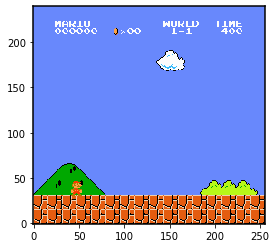

In [10]:
state = env.reset()
print('State Shape', state.shape)
plt.imshow(state[0]).origin='upper'

### GrayScaleObservation Off and VecFrameStack On

In [11]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, False, True, 4, 'last')

State Shape (1, 240, 256, 12)


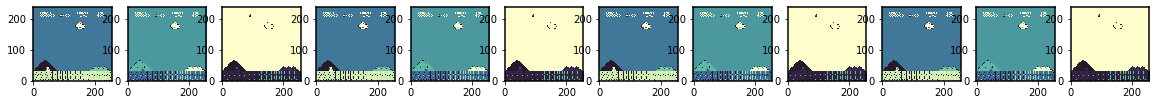

In [12]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(12): # So there'll be 4 images with 3 channels
    plt.subplot(1,12,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

### GrayScaleObservation and VecFrameStack On

In [13]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')

State Shape (1, 240, 256, 4)


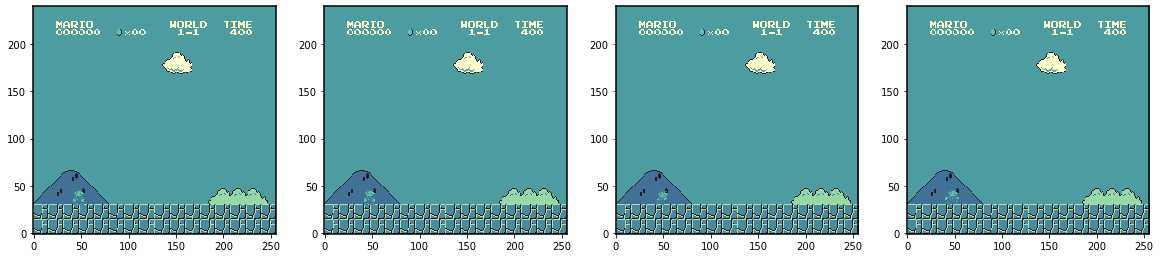

In [14]:
state = env.reset()
print('State Shape', state.shape)
for i in range(0,4): # Filling our vector with images
    state, reward, done, info = env.step([env.action_space.sample()]) # Note that the brackets around the env.action... are
# because we have wrapped it

plt.figure(figsize=(20,20))
for idx in range(state.shape[3]): # So there'll be 4 images
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx]).origin='upper' # idx is in ranging through 1-4
    plt.show

# Train the RL Model

## Setting up the logging

In [17]:
# Training and Logging Callback function

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [18]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [19]:
# Setup model saving callback

check_freq = 10000
callback = TrainAndLoggingCallback(check_freq=check_freq, save_path=CHECKPOINT_DIR)

## Setting up the environment

In [20]:
env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
state = env.reset()
print('State shape', state.shape)

(1, 240, 256, 4)


## Defining and Training the Model

### Setting up the model

In [29]:
# PPO Model

def PPO_model(policy, env, verbose, log_dir, lr, n_steps):
    """
    policy is a string and can be 'MlpPolicy' or 'CnnPolicy'
    n_steps is the number of time-steps in a trajectory
    learning_rate is the learning rate for the optimizer, which is Adam by default
    """
    if log_dir == 'None':
        model = PPO(policy, env, verbose=verbose, learning_rate=lr, 
            n_steps=n_steps) 
    else: 
        model = PPO(policy, env, verbose=verbose, tensorboard_log=log_dir, learning_rate=lr, 
            n_steps=n_steps) 
    
    return model

### Training

In [25]:
# Training

def model_learning(model, time_steps, callback):
    
    if callback == 'None':
        model.learn(total_timesteps=time_steps)
    else:
        model.learn(total_timesteps=time_steps, callback = callback)

In [30]:
model = PPO_model('CnnPolicy', env, 1, 'None', 1e-5, 512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [31]:
model_learning(model, 100000, 'None')

----------------------------
| time/              |     |
|    fps             | 77  |
|    iterations      | 1   |
|    time_elapsed    | 6   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 15          |
|    iterations           | 2           |
|    time_elapsed         | 65          |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.004020581 |
|    clip_fraction        | 0.0203      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | -0.000397   |
|    learning_rate        | 1e-05       |
|    loss                 | 42.5        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00328    |
|    value_loss           | 176         |
-----------------------------------------
-----------------------------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 13          |
|    time_elapsed         | 983         |
|    total_timesteps      | 6656        |
| train/                  |             |
|    approx_kl            | 0.005869755 |
|    clip_fraction        | 0.000977    |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.339       |
|    learning_rate        | 1e-05       |
|    loss                 | 0.0384      |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.00347    |
|    value_loss           | 0.35        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 6            |
|    iterations           | 14           |
|    time_elapsed         | 1068         |
|    total_timesteps      | 7

-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 24          |
|    time_elapsed         | 1916        |
|    total_timesteps      | 12288       |
| train/                  |             |
|    approx_kl            | 0.013140924 |
|    clip_fraction        | 0.0982      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0153      |
|    learning_rate        | 1e-05       |
|    loss                 | 0.0872      |
|    n_updates            | 230         |
|    policy_gradient_loss | -0.00984    |
|    value_loss           | 0.336       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 25          |
|    time_elapsed         | 2005        |
|    total_timesteps      | 12800 

------------------------------------------
| time/                   |              |
|    fps                  | 6            |
|    iterations           | 35           |
|    time_elapsed         | 2913         |
|    total_timesteps      | 17920        |
| train/                  |              |
|    approx_kl            | 0.0037461605 |
|    clip_fraction        | 0.0486       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.558       |
|    explained_variance   | 0.104        |
|    learning_rate        | 1e-05        |
|    loss                 | 216          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.00467     |
|    value_loss           | 436          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 36          |
|    time_elapsed         | 3008        |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 46          |
|    time_elapsed         | 3871        |
|    total_timesteps      | 23552       |
| train/                  |             |
|    approx_kl            | 0.009033326 |
|    clip_fraction        | 0.026       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.981      |
|    explained_variance   | 0.538       |
|    learning_rate        | 1e-05       |
|    loss                 | 95.1        |
|    n_updates            | 450         |
|    policy_gradient_loss | 0.000378    |
|    value_loss           | 345         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 6           |
|    iterations           | 47          |
|    time_elapsed         | 3956        |
|    total_timesteps      | 24064 

----------------------------------------
| time/                   |            |
|    fps                  | 5          |
|    iterations           | 57         |
|    time_elapsed         | 4898       |
|    total_timesteps      | 29184      |
| train/                  |            |
|    approx_kl            | 0.00294779 |
|    clip_fraction        | 0          |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.06      |
|    explained_variance   | 0.856      |
|    learning_rate        | 1e-05      |
|    loss                 | 94.9       |
|    n_updates            | 560        |
|    policy_gradient_loss | -0.00164   |
|    value_loss           | 194        |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 58          |
|    time_elapsed         | 5032        |
|    total_timesteps      | 29696       |
| train/  

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 68           |
|    time_elapsed         | 6496         |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0026557301 |
|    clip_fraction        | 0.0729       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.916       |
|    explained_variance   | 0.255        |
|    learning_rate        | 1e-05        |
|    loss                 | 130          |
|    n_updates            | 670          |
|    policy_gradient_loss | -0.00437     |
|    value_loss           | 703          |
------------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 5          |
|    iterations           | 69         |
|    time_elapsed         | 6605       |
|    total_timesteps 

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 79           |
|    time_elapsed         | 7622         |
|    total_timesteps      | 40448        |
| train/                  |              |
|    approx_kl            | 0.0024335682 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.656       |
|    explained_variance   | 0.719        |
|    learning_rate        | 1e-05        |
|    loss                 | 133          |
|    n_updates            | 780          |
|    policy_gradient_loss | -5.88e-05    |
|    value_loss           | 214          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 80           |
|    time_elapsed         | 7720         |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 90          |
|    time_elapsed         | 8656        |
|    total_timesteps      | 46080       |
| train/                  |             |
|    approx_kl            | 0.001885303 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.748      |
|    explained_variance   | 0.566       |
|    learning_rate        | 1e-05       |
|    loss                 | 323         |
|    n_updates            | 890         |
|    policy_gradient_loss | -0.00486    |
|    value_loss           | 510         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 91          |
|    time_elapsed         | 8746        |
|    total_timesteps      | 46592 

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 101         |
|    time_elapsed         | 9668        |
|    total_timesteps      | 51712       |
| train/                  |             |
|    approx_kl            | 0.011811616 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.901      |
|    explained_variance   | 0.633       |
|    learning_rate        | 1e-05       |
|    loss                 | 325         |
|    n_updates            | 1000        |
|    policy_gradient_loss | -0.00187    |
|    value_loss           | 550         |
-----------------------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 5          |
|    iterations           | 102        |
|    time_elapsed         | 9766       |
|    total_timesteps      | 52224      

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 112         |
|    time_elapsed         | 10795       |
|    total_timesteps      | 57344       |
| train/                  |             |
|    approx_kl            | 0.012959646 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | -0.156      |
|    learning_rate        | 1e-05       |
|    loss                 | 0.0436      |
|    n_updates            | 1110        |
|    policy_gradient_loss | -0.00664    |
|    value_loss           | 0.136       |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 113         |
|    time_elapsed         | 10897       |
|    total_timesteps      | 57856 

----------------------------------------
| time/                   |            |
|    fps                  | 5          |
|    iterations           | 123        |
|    time_elapsed         | 11930      |
|    total_timesteps      | 62976      |
| train/                  |            |
|    approx_kl            | 0.01717456 |
|    clip_fraction        | 0.099      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.76      |
|    explained_variance   | -0.03      |
|    learning_rate        | 1e-05      |
|    loss                 | 0.109      |
|    n_updates            | 1220       |
|    policy_gradient_loss | -0.0102    |
|    value_loss           | 0.334      |
----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 124         |
|    time_elapsed         | 12043       |
|    total_timesteps      | 63488       |
| train/  

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 134          |
|    time_elapsed         | 13015        |
|    total_timesteps      | 68608        |
| train/                  |              |
|    approx_kl            | 0.0006883405 |
|    clip_fraction        | 0.00605      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.521       |
|    explained_variance   | 0.666        |
|    learning_rate        | 1e-05        |
|    loss                 | 160          |
|    n_updates            | 1330         |
|    policy_gradient_loss | -0.000501    |
|    value_loss           | 405          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 135          |
|    time_elapsed         | 13117        |
|    total_

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 145         |
|    time_elapsed         | 14100       |
|    total_timesteps      | 74240       |
| train/                  |             |
|    approx_kl            | 0.018262438 |
|    clip_fraction        | 0.0543      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.701      |
|    explained_variance   | 0.464       |
|    learning_rate        | 1e-05       |
|    loss                 | 171         |
|    n_updates            | 1440        |
|    policy_gradient_loss | -0.00165    |
|    value_loss           | 723         |
-----------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 146         |
|    time_elapsed         | 14217       |
|    total_timesteps      | 74752 

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 156          |
|    time_elapsed         | 15117        |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 0.0045785606 |
|    clip_fraction        | 0.0504       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.422       |
|    explained_variance   | 0.347        |
|    learning_rate        | 1e-05        |
|    loss                 | 40.3         |
|    n_updates            | 1550         |
|    policy_gradient_loss | -0.00411     |
|    value_loss           | 133          |
------------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 157          |
|    time_elapsed         | 15198        |
|    total_

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 167          |
|    time_elapsed         | 16023        |
|    total_timesteps      | 85504        |
| train/                  |              |
|    approx_kl            | 0.0018539445 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.676       |
|    explained_variance   | 0.713        |
|    learning_rate        | 1e-05        |
|    loss                 | 75.4         |
|    n_updates            | 1660         |
|    policy_gradient_loss | -0.000395    |
|    value_loss           | 209          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 168         |
|    time_elapsed         | 16097       |
|    total_times

------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 178          |
|    time_elapsed         | 16827        |
|    total_timesteps      | 91136        |
| train/                  |              |
|    approx_kl            | 0.0038750656 |
|    clip_fraction        | 0.0234       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.286       |
|    explained_variance   | 0.759        |
|    learning_rate        | 1e-05        |
|    loss                 | 50.6         |
|    n_updates            | 1770         |
|    policy_gradient_loss | -0.0019      |
|    value_loss           | 126          |
------------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 179         |
|    time_elapsed         | 16901       |
|    total_times

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 189         |
|    time_elapsed         | 17628       |
|    total_timesteps      | 96768       |
| train/                  |             |
|    approx_kl            | 0.002619918 |
|    clip_fraction        | 0.0262      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.246      |
|    explained_variance   | 0.762       |
|    learning_rate        | 1e-05       |
|    loss                 | 71.2        |
|    n_updates            | 1880        |
|    policy_gradient_loss | -0.00348    |
|    value_loss           | 116         |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 190          |
|    time_elapsed         | 17700        |
|    total_timesteps      | 9

# Evaluation

In [37]:
# Evaluating our model

def evaluate_mario(n_steps, render):
    
    env = set_up_env('SuperMarioBros-v0', SIMPLE_MOVEMENT, True, True, 4, 'last')
    
    # Start the game 
    state = env.reset()
    steps = 1000
    # Loop through the game
    rewards = []
    for i in range(steps):

        action, _ = model.predict(state)
        state, reward, done, info = env.step(action)
        rewards.append(reward)
        if render == True:
            env.render()
    env.close()  
    
    return np.sum(rewards)

In [39]:
# Single play-through

print('The agent recieved a total reward in one playthrough of', evaluate_mario(1000, True))

The total rewards during 1000 steps is 1251.0


In [ ]:
# Multiple play-throughs

rewards_list = []
n_traj = 10
for i in range(n_traj):
    rewards_list.append(evaluate_mario(1000, False))
print('The average reward after', n_traj, 'trajectories is', np.mean(rewards_list))

# Saving and Reloading the Model

In [32]:
# Save the model

model.save('Models/PPO.h5')

In [ ]:
# Reload the model

model = PPO.load('Models/PPO.h5')